## LangGraph 내장 도구(tool) 활용 
- LangGraph는 많은 내장 도구들을 제공한다. 
- https://docs.langchain.com/oss/python/integrations/tools
- 커스텀 도구를 만들기 전에 내장 도구를 먼저 확인하면 개발 효율을 높일 수 있다. 
- 사용해 볼 랭그래프 내장 도구
    - 웹 검색 도구: DuckDuckGo
    - 구글 메일 도구: GmailToolkit
    - 논문사이트에서 논문 가져오는 도구: arxiv
    - 벡터DB 검색 도구: create_retriever_tool

In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

### 1. 더하기, 곱하기 Tool 

In [2]:
from langchain_core.tools import tool

@tool 
def add(a: int, b:int) -> int:
    """숫자 a와 b를 더합니다.""" 
    return a + b

@tool
def multiply(a: int, b:int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [3]:
#add.invoke({'a': 4, 'b': 8})
#multiply.invoke({'a': 4, 'b': 8})

### 2. 웹 검색 Tool: DuckDuckGo

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

web_search_tool = DuckDuckGoSearchRun()

#web_search_tool.invoke("오바마가 태어난 곳의 화폐 단위는?")

### 3. 구글 메일 Tool : GmailToolkit


In [5]:
import inspect
from langchain_google_community.gmail.utils import get_gmail_credentials

inspect.signature(get_gmail_credentials)

<Signature (token_file: 'Optional[str]' = None, client_sercret_file: 'Optional[str]' = None, service_account_file: 'Optional[str]' = None, scopes: 'Optional[List[str]]' = None, use_domain_wide: 'bool' = False, delegated_user: 'Optional[str]' = None) -> 'Credentials'>

In [6]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="../google/token.json", #나중에 만들어지는 파일 
    scopes=["https://mail.google.com/"],
    client_sercret_file="../google/credentials.json",
)

api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

#app publish, gmail API 승인 필요 

/var/folders/h2/84bkz1z16w5c0lv50z7fjm_40000gn/T/ipykernel_65973/1023507223.py:9: DeprecationWarning: get_gmail_credentials is deprecated and will be removed in a future version.Use get_google_credentials instead.
  credentials = get_gmail_credentials(
/var/folders/h2/84bkz1z16w5c0lv50z7fjm_40000gn/T/ipykernel_65973/1023507223.py:15: DeprecationWarning: build_resource_service is deprecated and will be removed in a future version.Use build_gmail_service instead.
  api_resource = build_resource_service(credentials=credentials)


In [7]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x11a340bd0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x11a340bd0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x11a340bd0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x11a340bd0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x11a340bd0>)]

### 4. 논문 가져오는 Tool: arxiv 

In [8]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.utilities.arxiv import ArxivAPIWrapper

arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())

### 5. Retriever Tool: create_retriever_tool
create_retriever_tool의 역할
1. 인터페이스 변환: 단순한 retriever 객체는 파이썬 코드상에서만 동작하는 검색기일 뿐이지만, 이 함수를 거치면 **이름, 설명, 입력값 정의**를 갖춘 Tool 객체로 변신합니다.
2. LLM용 설명서 제공: 'name'과 'description'을 통해 에이전트가 "언제, 어떤 질문에 이 도구를 써야 하는지" 스스로 판단하게 합니다.
3. 자동 실행 로직: 에이전트가 특정 쿼리를 던지면, 내부적으로 retriever.get_relevant_documents()를 실행하여 관련 문서를 찾아오는 기능을 래핑(Wrapping)합니다.

In [18]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'real_estate_tax',
    persist_directory='../real_estate_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description="2024년 12월까지의 부동산 세금(취득세, 보유세, 양도소득세 등) 정보를 포함하고 있습니다. 부동산 세금 관련 법령이나 계산 방식에 대한 질문이 들어오면 이 도구를 사용하세요.",
)

## 그래프 조립

In [10]:
from langgraph.prebuilt import ToolNode

#함수 객체 리스트 정의 
tool_list = [add, multiply, web_search_tool, arxiv_tool, retriever_tool] + gmail_tool_list

#모델에 도구 설명서 전달 
#llm_with_tools = small_llm.bind_tools(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

#함수 객체 리스트를 전달받아, llm의 도구 호출 지시에 따라 실제로 파이썬 함수를 실행하는 노드를 생성
tool_node = ToolNode(tool_list)

In [11]:
from langgraph.graph import MessagesState, StateGraph

# graph_builder = StateGraph(AgentState)
graph_builder = StateGraph(MessagesState)

In [12]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지 (AIMessage)를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지 리스트를 추출합니다.
    messages = state['messages']
    
    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [14]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges(
    'agent',
    tools_condition,
)
graph_builder.add_edge('tools', 'agent')

In [15]:
graph = graph_builder.compile()

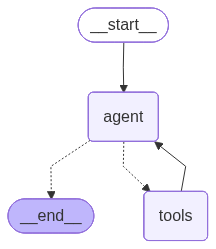

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
from langchain_core.messages import HumanMessage


#query = "3에다 5를 더하고 거기에 8을 곱하면?"
#query = "오바마가 태어난 도시의 화폐 단위는 무엇인가요?"
#query = "What currency is Billy Giles' Birthplace?"
#query = "'에이전트 테스트' 라고 leehnjee@gmail.com 으로 이메일을 보내주세요."
#query = "Attention is All You Need라는 논문을 요약해서 leehnjee@gmail.com으로 메일 보내주세요."
query = "집이 15억일 때 종합부동산세를 알려주세요."

#graph.invoke({"messages": [HumanMessage(query)]})

# stream으로 실행하여 기록 출력하기 
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 15억일 때 종합부동산세를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_NGT8VgPKBRVBvhb33Ryjsirn)
 Call ID: call_NGT8VgPKBRVBvhb33Ryjsirn
  Args:
    query: 시가 15억 종합부동산세
================================= Tool Message =================================
Name: real_estate_tax_retriever


================================== Ai Message ==================================

아래는 시가 15억 원의 부동산에 대한 종합부동산세 관련 정보입니다:

1. **공정시장가액비율**: 종합부동산세를 계산할 때 사용하는 공정시장가액비율은 60%입니다.
   
2. **과세표준**: 공시가격(시가)에서 공정시장가액비율을 적용한 금액에서 일정 공제액을 뺀 금액을 기준으로 합니다. 경감분을 제외하면 15억 원 주택의 경우 대략 9억 원이 과세 표준이 될 수 있습니다.

3. **세율**: 종합부동산세는 과세표준에 따라 다른 세율이 적용되며, 일반적으로 0.5%에서 3.0% 사이의 세율이 적용됩니다.

4. **경감 및 공제**: 1가구 1주택자나 기타 요건에 따라 추가 경감 또는 공제가 있을 수 있습니다.

정확한 계산을 위해서는 공시가격을 바탕으로 한 자세한 과세표준 산출과 세율 적용을 필요로 하기 때문에, 실제 세무 전문가와 상담하거나, 관련 공공기관의 안내를 받는 것이 좋습니다.
